# Use the model to make predictions on the un-seen training set then verify the labels.

The initial small model was trained on a subset of the training data. 

Cleaning of the training set can proceed in the same manner as the cleaning of the validation set - either by picking 1000 samples from each class to manually verify, or by sorting the samples by highest loss and cleaning out the top 20% of errors. 

Manually checking 1000 samples takes about 4-5 hours. 

# Clips will be listened to and labelled with the following confidence categories:

Confidence scores:
- 0 UNCHECKED means it hasn't been verified
- 1 DISCARD is something to throw out, 
- 2 UNSURE is not sure
- 3 VERIFIED means the label is definitely correct
- 4 FOCAL means the present label is correct and the target species vocalization is prominent
- 5 Label needs changing from absent to present 
- 6 Label needs changing from present to absent

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import sys
BASE_PATH = Path.cwd().parent.parent
data_path = BASE_PATH / "data"
model_save_path = BASE_PATH / "models"
sys.path.append(str(BASE_PATH))
import opensoundscape as opso
from opensoundscape import Audio, Spectrogram
from opensoundscape.preprocess.utils import show_tensor
from src.utils import verify_samples, remove_short_clips
from matplotlib import pyplot as plt

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/ml/cnn.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Load the training set
train_df = pd.read_pickle(data_path / "interim" / "train_set" / "train_set.pkl")
train_df = remove_short_clips(train_df)
train_ds = train_df[["target_present"]]
train_df.target_present.value_counts()

7 short clips dropped from the dataframe:


target_present
0.0    35377
1.0     2296
Name: count, dtype: int64

# Load a model and make predictions on the unseen training set. 

#### * Skip this section if verification has already begun.

In [4]:
model = opso.cnn.load_model(model_save_path / "initial_small.model")
predictions = model.predict(train_ds, batch_size=64, activation_layer="sigmoid")
# predictions.rename(columns={"target_present": "predicted"}, inplace=True)

  0%|          | 0/589 [00:00<?, ?it/s]

# If you got the following error during this stage
"__Audio object is shorter than requested duration__"


Run the notebook again and the error samples will be automatically cleaned on the next run. 

In [5]:
train_df['predicted'] = predictions['target_present']

In [6]:
def calculate_loss(df):
    return abs(df["target_present"] - df["predicted"])

train_df["loss"] = calculate_loss(train_df)


# add a column to the dataframe to store the confidence of the label, if it doesn't alredy exist
if 'confidence_cat' not in train_df.columns:
    train_df['confidence_cat'] = 0

# * If cleaning has already begun, load the cleaned data here instead
This will load any previously entered confidence category work. 

In [7]:
if Path.exists(data_path / "interim" / "train_set" / "train_set_verified.pkl"):
    train_df_verified = pd.read_pickle(data_path / "interim" / "train_set" / "train_set_verified.pkl")
else:
    train_df_verified = train_df

target = 1.0, prediction = 0.307175874710083 loss = 0.692824125289917


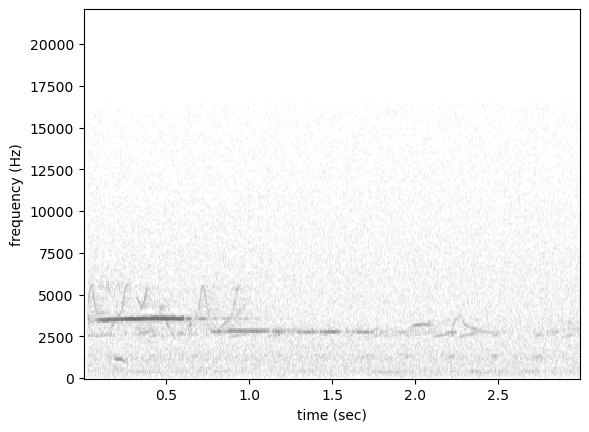

added confidence tag 3 to the dataframe.
confidence_cat
0    1977
6     170
2     105
3      44
Name: count, dtype: int64


/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/src/utils.py:386: PerformanceWarning: indexing past lexsort depth may impact performance.
  df.loc[clip_idx, "confidence_cat"] = int(user_confidence)


In [326]:
train_df_verified = verify_samples(train_df_verified, ground_truth=1.0, loss_sorted=True)

To cycle through the samples, hit ctrl+enter to execute the current code cell and keep it focussed. 

<Axes: xlabel='confidence_cat'>

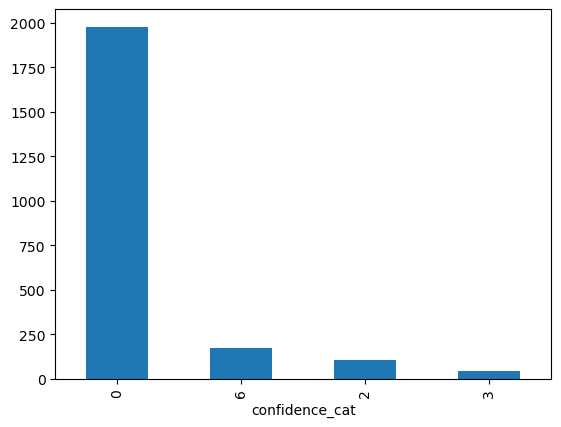

In [333]:
counts = train_df_verified.loc[train_df_verified.target_present==1.0].confidence_cat.value_counts()
# plot the counts and re-label the x labels with the confidence categories
counts.plot(kind='bar')


After verifying the present samples in the training set

# Verify the absent class
The absent class is much larger than the present class, so we'll use a different strategy to clean the samples:

- Go through the samples with the highest loss and re-label those which actually contain the target class. 

- Take a sample of 1000 absent and 1000 present samples and verify each of these. 

- We can take advantage of the small model's predictions and our verification work to add more confusing samples into the training data: take 200 samples from the top end of the loss sorted training set, which were also confirmed as belonging to the absent class, and add these to the absent class of the training data. 

- This will give us a fully checked training set with equal numbers of samples from each class. The training set will include examples in the absent class which were most confusing in the previous run. 

- Additionally we'll have gone through the top section of samples in the training set which are a mixture of mis-labels and easily confused vocalizations. This would be a good time to start noticing any other species which have similar calls to the target species. Try downloading them and uploading their recordings at https://birdnet.cornell.edu/api/ then verifying the ID [here](https://academy.allaboutbirds.org/peterson-field-guide-to-bird-sounds/?speciesCode=olsfly&species=Olive-sided%20Flycatcher%20-%20Contopus%20cooperi). 

target = 0.0, prediction = 0.9955487251281738 loss = 0.9955487251281738


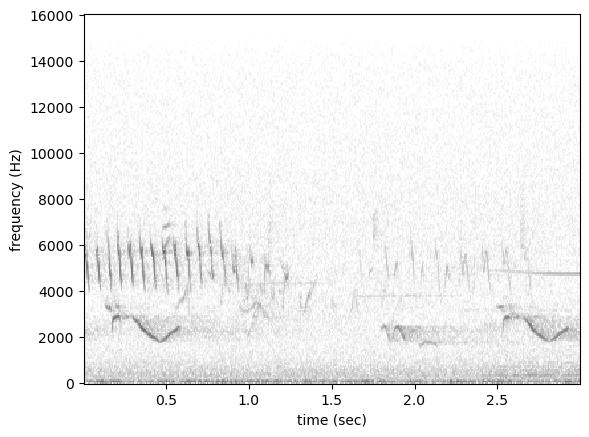

added confidence tag 3 to the dataframe.
verification counts for target_present = 0.0
confidence_cat
0    35371
3        4
2        1
5        1
Name: count, dtype: int64


/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/src/utils.py:386: PerformanceWarning: indexing past lexsort depth may impact performance.
  df.loc[clip_idx, "confidence_cat"] = int(user_confidence)


In [ ]:
train_df_verified = verify_samples(train_df_verified, ground_truth=0.0, loss_sorted=True)

In [ ]:
# # Re-label mistaken sample here
# valid_df_verified.loc[valid_df_verified.predicted == 0.9979363679885864, 'confidence_cat'] = 0


In [335]:
# plot the counts of verification work on the absent class. 
train_df_verified.loc[train_df_verified.target_present==0.0].confidence_cat.value_counts()

confidence_cat
0    35371
3        4
2        1
5        1
Name: count, dtype: int64

In [ ]:
# Build a balanced training set.

n_samples_per_class = 1000
# Choose all of the focal present samples
focal_present = train_df_verified.loc[train_df_verified.target_present==1.0].loc[train_df_verified.confidence_cat==4]
# Choose a random sample of the remaining present samples
present = train_df_verified.loc[train_df_verified.target_present==1.0].loc[train_df_verified.confidence_cat==3]
present = pd.concat([focal_present, present.sample(n=n_samples_per_class-len(focal_present))])
print(len(present))

# Choose a random sample of 1200 absent samples to verify - knowing that we'll want to end up with 1000 and some will be mis-labelled.
absent = train_df_verified.loc[train_df_verified.target_present==0.0].sample(n=n_samples_per_class + 200)


400


target = 0.0, prediction = 0.10509130358695984 loss = 0.10509130358695984


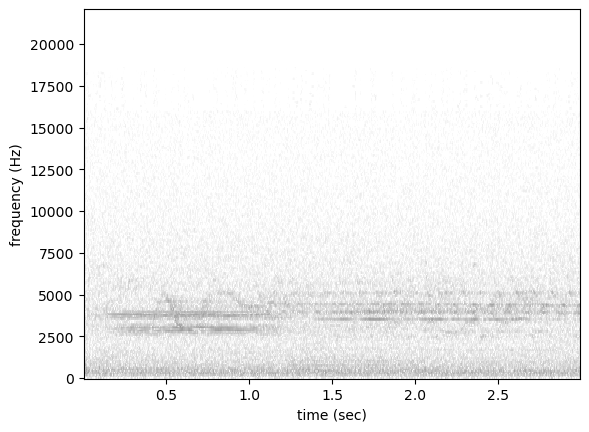

added confidence tag 3 to the dataframe.
confidence_cat
3    433
0     52
5      9
2      6
Name: count, dtype: int64


/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/src/utils.py:385: PerformanceWarning: indexing past lexsort depth may impact performance.
  df.loc[clip_idx, "confidence_cat"] = int(user_confidence)


In [ ]:
absent = verify_samples(absent, ground_truth=0.0, loss_sorted=True)

# Construct a balanced training set from equal numbers of verified samples. 

In [ ]:
absent = absent.loc[absent.confidence_cat==3].sample(n=n_samples_per_class, random_state=42)
balanced_train_df = pd.concat([present, absent])

balanced_train_df.target_present.value_counts()

target_present
1.0    400
0.0    400
Name: count, dtype: int64

# Save the verification work to disk

In [336]:
train_df_verified.to_pickle(data_path / "interim" / "train_set" / "train_set_verified.pkl")

In [ ]:
balanced_train_df.to_pickle(data_path / "interim" / "train_set" / "balanced_train_set_verified.pkl")

In [ ]:
train_df_verified.target_present.value_counts()

target_present
0.0    8571
1.0     687
Name: count, dtype: int64

# Concluding notes
**We started out with a data set which relied entirely on human labels from wildtrax. Some of these contained errors, so we trained an initial model using this noisy data, and used it as an aid for cleaning the validation set in the following way:

1. A set of 400 verified present samples and verified 400 absent samples were saved as __balanced_valid_set_verified__

2. A larger set of 8571 absent samples and 687 present samples is available too. The present samples were all checked, and the absent samples were sorted by highest error between prediction and label (loss), then the top few hundred of these were checked, until the model predictions were below 80% and there were relatively few actual present samples. A confidence category was assigned to these so that they can be re-labelled. This dataset is saved as __valid_set_verified__
**